In [1]:
#import the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
#setting pandas to show all columns of the dataframe without truncation
pd.set_option('display.max_columns', None)

In [3]:
#loading the data
df = pd.read_csv('cleaned_dataset.csv')
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Time_bin,Manufactured_year,Age,Year_month,Date_time,Delay_status
0,2007,9,27,4,1104,1105,1243,1255,WN,110,N741SA,99.0,110.0,82.0,-12.0,-1.0,SEA,SMF,605,5,12,0,0,0,0,0,10am - 12pm,1998,9,2007-09,2007-09-27 11:05:00,0
1,2007,11,20,2,2120,2120,2255,2308,EV,4304,N355CA,95.0,108.0,67.0,-13.0,0.0,ATL,CLE,554,10,18,0,0,0,0,0,8pm - 10pm,2002,5,2007-11,2007-11-20 21:20:00,0
2,2007,7,16,1,1025,1030,1127,1133,OO,5799,N284YV,62.0,63.0,54.0,-6.0,-5.0,PDX,MFR,222,2,6,0,0,0,0,0,10am - 12pm,1994,13,2007-07,2007-07-16 10:30:00,0
3,2007,8,5,7,1448,1453,1529,1538,AQ,94,N837AL,41.0,45.0,32.0,-9.0,-5.0,HNL,KOA,163,2,7,0,0,0,0,0,2pm - 4pm,1985,22,2007-08,2007-08-05 14:53:00,0
4,2006,12,10,7,2027,1921,2235,2138,OO,6704,N943SW,68.0,77.0,55.0,57.0,66.0,DEN,LNK,423,3,10,0,0,0,0,57,6pm - 8pm,2003,3,2006-12,2006-12-10 19:21:00,1


In [4]:
#checking the number of rows and columns of the dataframe
df.shape

(5750846, 32)

In [5]:
#removing some categorical variables which won't be encoded into the model
df.drop(['Year', 'DayofMonth', 'UniqueCarrier','FlightNum', 'Origin', 'Dest', 'Time_bin', 'Manufactured_year',
         'Year_month'],inplace = True, axis = 1)

In [6]:
#removing columns with actual times values that have already passed, other than ArrDelay, DepDelay and Taxi times
df.drop(['DepTime', 'ArrTime', 'ActualElapsedTime', 'AirTime'],inplace = True, axis = 1)

In [7]:
#having a look at the dataframe
df.head()

,Month,DayOfWeek,CRSDepTime,CRSArrTime,TailNum,CRSElapsedTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Age,Date_time,Delay_status
0,9,4,1105,1255,N741SA,110.0,-12.0,-1.0,605,5,12,0,0,0,0,0,9,2007-09-27 11:05:00,0
1,11,2,2120,2308,N355CA,108.0,-13.0,0.0,554,10,18,0,0,0,0,0,5,2007-11-20 21:20:00,0
2,7,1,1030,1133,N284YV,63.0,-6.0,-5.0,222,2,6,0,0,0,0,0,13,2007-07-16 10:30:00,0
3,8,7,1453,1538,N837AL,45.0,-9.0,-5.0,163,2,7,0,0,0,0,0,22,2007-08-05 14:53:00,0
4,12,7,1921,2138,N943SW,77.0,57.0,66.0,423,3,10,0,0,0,0,57,3,2006-12-10 19:21:00,1


#### Creating a new column with the planes' arrival delay at the prior airport to help predict arrival delay at the next airport

In [8]:
#sorting by tail number and then Datetime
df = df.sort_values(["TailNum", "Date_time"]).set_index("Date_time")

In [9]:
#comparing the current delay with the next delay
df["Prior_delay"] = df["ArrDelay"].shift(1)

#checking the new Prior_delay column
df.head()

,Month,DayOfWeek,CRSDepTime,CRSArrTime,TailNum,CRSElapsedTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Age,Delay_status,Prior_delay
Date_time,,,,,,,,,,,,,,,,,,,
2006-01-01 16:20:00,1,7,1620,1820,N10156,180.0,-9.0,-8.0,1043,14,11,0,0,0,0,0,2,0,NaN
2006-01-02 14:35:00,1,1,1435,1653,N10156,198.0,-3.0,6.0,1157,8,12,0,0,0,0,0,2,0,-9.0
2006-01-03 10:25:00,1,2,1025,1345,N10156,140.0,60.0,62.0,913,4,12,0,0,0,0,60,2,1,-3.0
2006-01-03 14:15:00,1,2,1415,1605,N10156,110.0,363.0,182.0,529,10,196,0,0,363,0,0,2,1,60.0
2006-01-04 06:50:00,1,3,650,810,N10156,80.0,67.0,68.0,284,12,15,67,0,0,0,0,2,1,363.0


In [10]:
#dropping null values
df.dropna(inplace=True)

In [11]:
#checking the number of columns, rows and datatypes of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5750845 entries, 2006-01-02 14:35:00 to 2007-12-31 18:40:00
Data columns (total 19 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Month              int64  
 1   DayOfWeek          int64  
 2   CRSDepTime         int64  
 3   CRSArrTime         int64  
 4   TailNum            object 
 5   CRSElapsedTime     float64
 6   ArrDelay           float64
 7   DepDelay           float64
 8   Distance           int64  
 9   TaxiIn             int64  
 10  TaxiOut            int64  
 11  CarrierDelay       int64  
 12  WeatherDelay       int64  
 13  NASDelay           int64  
 14  SecurityDelay      int64  
 15  LateAircraftDelay  int64  
 16  Age                int64  
 17  Delay_status       int64  
 18  Prior_delay        float64
dtypes: float64(4), int64(14), object(1)
memory usage: 877.5+ MB


In [12]:
#binning the hours of the day into 4 time slots, of 6 hours each
def categorise(row):  
    if row['CRSDepTime'] >= 0 and row['CRSDepTime'] <= 759:
        return '12am - 8am'
    elif row['CRSDepTime'] >= 800  and row['CRSDepTime'] <= 1559:
        return '8am - 4pm'
    elif row['CRSDepTime'] >= 1600  and row['CRSDepTime'] <= 2359:
        return '4pm - 12am'

df['Time_slot'] = df.apply(lambda row: categorise(row), axis=1)

In [13]:
#creating a lambda function to map the DayOfWeek to the days of the week, and turn it into a categorical variable
days = lambda day: 'Monday' if day in [1] else \
                    'Tuesday' if day in [2] else \
                    'Wednesday' if day in [3] else \
                    'Thursday' if day in [4] else \
                    'Friday' if day in [5] else \
                    'Saturday' if day in [6] else 'Sunday'

df['Day'] = df['DayOfWeek'].apply(days)

In [14]:
#creating and applying a lambda function to map months to seasons, and storing it in a new column
season = lambda month: 'Spring' if month in [3, 4, 5] else \
                           'Summer' if month in [6, 7, 8] else \
                           'Autumn' if month in [9, 10, 11] else 'Winter'

df['Season'] = df['Month'].apply(season)

In [15]:
df.head()

,Month,DayOfWeek,CRSDepTime,CRSArrTime,TailNum,CRSElapsedTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Age,Delay_status,Prior_delay,Time_slot,Day,Season
Date_time,,,,,,,,,,,,,,,,,,,,,,
2006-01-02 14:35:00,1,1,1435,1653,N10156,198.0,-3.0,6.0,1157,8,12,0,0,0,0,0,2,0,-9.0,8am - 4pm,Monday,Winter
2006-01-03 10:25:00,1,2,1025,1345,N10156,140.0,60.0,62.0,913,4,12,0,0,0,0,60,2,1,-3.0,8am - 4pm,Tuesday,Winter
2006-01-03 14:15:00,1,2,1415,1605,N10156,110.0,363.0,182.0,529,10,196,0,0,363,0,0,2,1,60.0,8am - 4pm,Tuesday,Winter
2006-01-04 06:50:00,1,3,650,810,N10156,80.0,67.0,68.0,284,12,15,67,0,0,0,0,2,1,363.0,12am - 8am,Wednesday,Winter
2006-01-04 09:35:00,1,3,935,1144,N10156,189.0,16.0,15.0,872,5,39,3,0,1,0,12,2,1,67.0,8am - 4pm,Wednesday,Winter


In [16]:
#dropping TailNum as it will not be encoded into the model, and other already encoded columns
df.drop(['TailNum', 'Month', 'DayOfWeek', 'CRSDepTime', 'ArrDelay'],inplace = True, axis = 1)

In [17]:
#checking which variables are categorical and numerical and assigning them to two lists
numerical_list = []
catergorical_list = []

for column in df.columns:
    if is_numeric_dtype(df[column]):
        numerical_list.append(column)
    elif is_string_dtype(df[column]):
        catergorical_list.append(column)

In [18]:
print(catergorical_list)

['Time_slot', 'Day', 'Season']


In [19]:
print(numerical_list)

['CRSArrTime', 'CRSElapsedTime', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Age', 'Delay_status', 'Prior_delay']


In [20]:
#getting dummy variables of the catergorical variables
df = pd.get_dummies(df, columns = catergorical_list)

In [21]:
df.head()

,CRSArrTime,CRSElapsedTime,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Age,Delay_status,Prior_delay,Time_slot_12am - 8am,Time_slot_4pm - 12am,Time_slot_8am - 4pm,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
Date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-02 14:35:00,1653,198.0,6.0,1157,8,12,0,0,0,0,0,2,0,-9.0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
2006-01-03 10:25:00,1345,140.0,62.0,913,4,12,0,0,0,0,60,2,1,-3.0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
2006-01-03 14:15:00,1605,110.0,182.0,529,10,196,0,0,363,0,0,2,1,60.0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
2006-01-04 06:50:00,810,80.0,68.0,284,12,15,67,0,0,0,0,2,1,363.0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2006-01-04 09:35:00,1144,189.0,15.0,872,5,39,3,0,1,0,12,2,1,67.0,0,0,1,0,0,0,0,0,0,1,0,0,0,1


In [22]:
#creating a new dataframe with only the numeric columns
numeric_df = df[numerical_list]

In [23]:
#getting a colour-blind friendly colour palette
sns.reset_orig()
my_palette = sns.color_palette("colorblind")
plt.style.use('seaborn-colorblind')

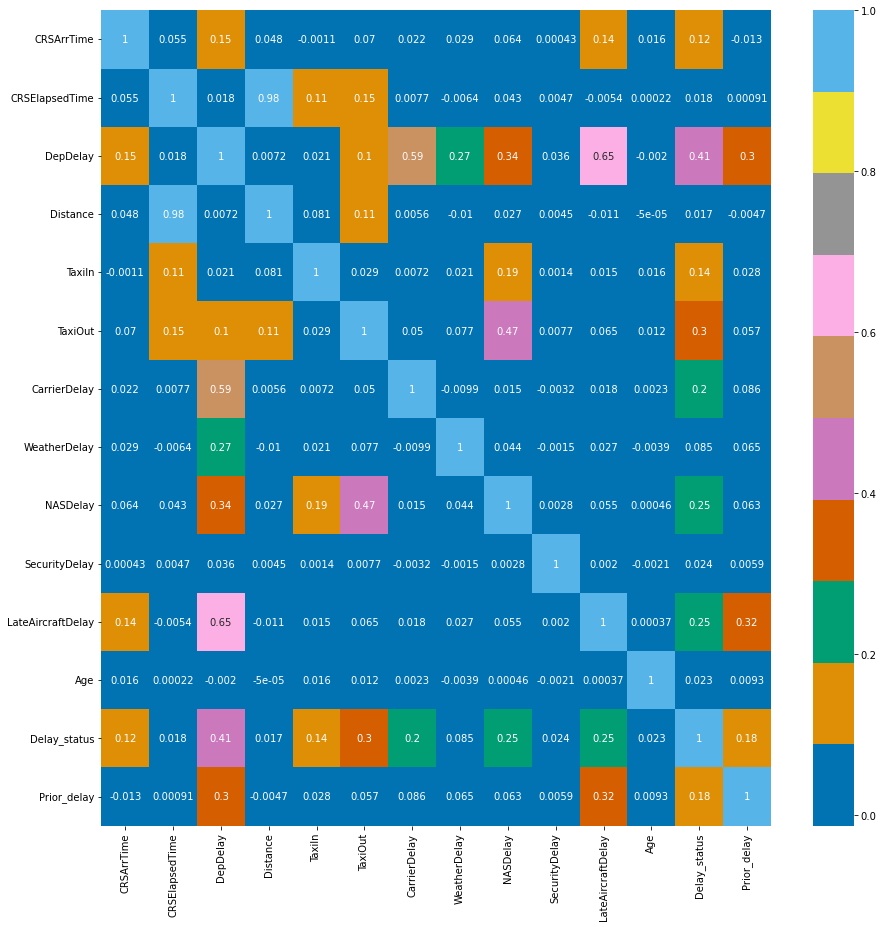

In [24]:
#now we check the correlation plot to see how 2 numerical variables are correlated
plt.figure(column,figsize = (15,15))
correlation = numeric_df.corr()
sns.heatmap(correlation,cmap = my_palette, annot = True)
plt.savefig('correlation matrix')
plt.show()

In [25]:
#split dataset into features and target variable
X = df.iloc[:,[2,5,14,15,16,17,18,19,20,21,22,23,24,25,26,27]]
Y = df.Delay_status

In [26]:
X.head()

,DepDelay,TaxiOut,Time_slot_12am - 8am,Time_slot_4pm - 12am,Time_slot_8am - 4pm,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
Date_time,,,,,,,,,,,,,,,,
2006-01-02 14:35:00,6.0,12,0,0,1,0,1,0,0,0,0,0,0,0,0,1
2006-01-03 10:25:00,62.0,12,0,0,1,0,0,0,0,0,1,0,0,0,0,1
2006-01-03 14:15:00,182.0,196,0,0,1,0,0,0,0,0,1,0,0,0,0,1
2006-01-04 06:50:00,68.0,15,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2006-01-04 09:35:00,15.0,39,0,0,1,0,0,0,0,0,0,1,0,0,0,1


In [27]:
#spliting data to train test split, with a training size of 0.75 and a test size of 0.25
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=1)

In [28]:
#scaling the dataset, first on X_train
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Development and testing

In [29]:
#calling the logistic regression model
logreg = LogisticRegression(random_state=1)

#fit the model with data
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

### Model evaluation

In [30]:
#checking for data imbalance to see if accuracy is a good metric to evaluate the model
df['Delay_status'].value_counts()

0    3051244
1    2699601
Name: Delay_status, dtype: int64

The classes of the 'Delay_status' seem to be imbalanced thus we will not use accuracy as a metric to evaluate the model.

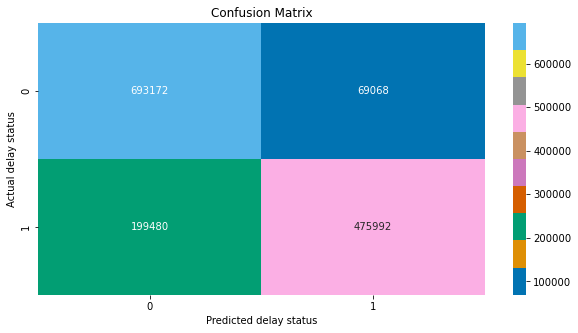

In [31]:
#creating a confusion matrix 
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(Y_test,Y_pred)
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, fmt='', cmap = my_palette)
plt.ylabel("Actual delay status")
plt.xlabel("Predicted delay status")
plt.savefig("confusion matrix")
plt.show()

In [32]:
#obtaining a classification report
from sklearn.metrics import classification_report
target_names = ['Not Delayed', 'Delayed']
print(classification_report(Y_test, Y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Not Delayed       0.78      0.91      0.84    762240
     Delayed       0.87      0.70      0.78    675472

    accuracy                           0.81   1437712
   macro avg       0.82      0.81      0.81   1437712
weighted avg       0.82      0.81      0.81   1437712



### ROC curve

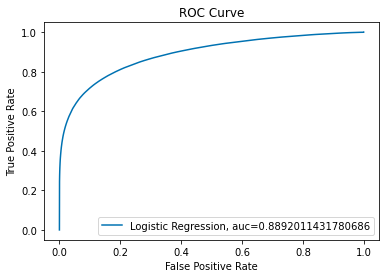

In [33]:
#plotting the ROC curve
Y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_pred_proba)
auc = metrics.roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc))
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc=4)
plt.savefig("ROC curve")
plt.show()